In this notebook, we will go through the salient features of the `openmc.data` package in the Python API. This package enables inspection, analysis, and conversion of nuclear data from ACE files. Most importantly, the package provides a mean to generate HDF5 nuclear data libraries that are used by the transport solver.

In [1]:
%matplotlib inline
import os
from pprint import pprint

import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm
from matplotlib.patches import Rectangle

import openmc.data

## Importing from HDF5

The `openmc.data` module can read OpenMC's HDF5-formatted data into Python objects. The easiest way to do this is with the `openmc.data.IncidentNeutron.from_hdf5(...)` factory method. Replace the `filename` variable below with a valid path to an HDF5 data file on your computer.

In [2]:
# Get filename for Gd-157
filename ='/home/romano/openmc/scripts/nndc_hdf5/Gd157.h5'

# Load HDF5 data into object
gd157 = openmc.data.IncidentNeutron.from_hdf5(filename)
gd157

<IncidentNeutron: Gd157>

## Cross sections

From Python, it's easy to explore (and modify) the nuclear data. Let's start off by reading the total cross section. Reactions are indexed using their "MT" number -- a unique identifier for each reaction defined by the ENDF-6 format. The MT number for the total cross section is 1.

In [3]:
total = gd157[1]
total

<Reaction: MT=1 (n,total)>

Cross sections for each reaction can be stored at multiple temperatures. To see what temperatures are available, we can look at the reaction's `xs` attribute.

In [4]:
total.xs

{'294K': <openmc.data.function.Sum at 0x7fc3263ca1d0>}

To find the cross section at a particular energy, 1 eV for example, simply get the cross section at the appropriate temperature and then call it as a function. Note that our nuclear data uses eV as the unit of energy.

In [5]:
total.xs['294K'](1.0)

142.6474702147809

The `xs` attribute can also be called on an array of energies.

In [6]:
total.xs['294K']([1.0, 2.0, 3.0])

array([ 142.64747021,   38.65417611,  175.40019668])

A quick way to plot cross sections is to use the `energy` attribute of `IncidentNeutron`. This gives an array of all the energy values used in cross section interpolation for each temperature present.

In [7]:
gd157.energy

{'294K': array([  1.00000000e-05,   1.03250000e-05,   1.06500000e-05, ...,
          1.95000000e+07,   1.99000000e+07,   2.00000000e+07])}

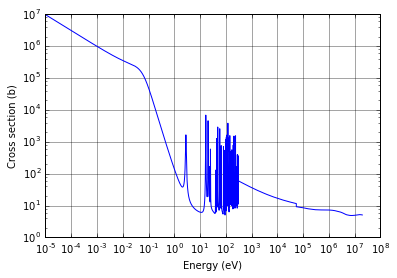

In [8]:
energies = gd157.energy['294K']
total_xs = total.xs['294K'](energies)
plt.loglog(energies, total_xs)
plt.xlabel('Energy (eV)')
plt.ylabel('Cross section (b)')

## Reaction Data

Most of the interesting data for an `IncidentNeutron` instance is contained within the `reactions` attribute, which is a dictionary mapping MT values to `Reaction` objects.

In [9]:
pprint(list(gd157.reactions.values())[:10])

[<Reaction: MT=2 (n,elastic)>,
 <Reaction: MT=16 (n,2n)>,
 <Reaction: MT=17 (n,3n)>,
 <Reaction: MT=22 (n,na)>,
 <Reaction: MT=24 (n,2na)>,
 <Reaction: MT=28 (n,np)>,
 <Reaction: MT=41 (n,2np)>,
 <Reaction: MT=51 (n,n1)>,
 <Reaction: MT=52 (n,n2)>,
 <Reaction: MT=53 (n,n3)>]


Let's suppose we want to look more closely at the (n,2n) reaction. This reaction has an energy threshold

In [10]:
n2n = gd157[16]
print('Threshold = {} eV'.format(n2n.xs['294K'].x[0]))

Threshold = 6400881.0 eV


The (n,2n) cross section, like all basic cross sections, is represented by the `Tabulated1D` class. The energy and cross section values in the table can be directly accessed with the `x` and `y` attributes. Using the `x` and `y` has the nice benefit of automatically acounting for reaction thresholds.

In [11]:
n2n.xs

{'294K': <openmc.data.function.Tabulated1D at 0x7fc3263ca4e0>}

(6400881.0, 20000000.0)

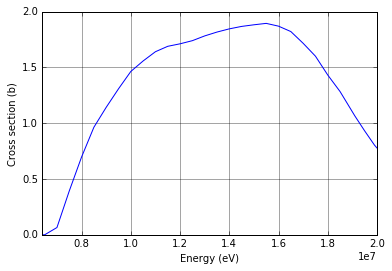

In [12]:
xs = n2n.xs['294K']
plt.plot(xs.x, xs.y)
plt.xlabel('Energy (eV)')
plt.ylabel('Cross section (b)')
plt.xlim((xs.x[0], xs.x[-1]))

To get information on the energy and angle distribution of the neutrons emitted in the reaction, we need to look at the `products` attribute.

In [13]:
n2n.products

[<Product: neutron, emission=prompt, yield=polynomial>,
 <Product: photon, emission=prompt, yield=tabulated>]

In [14]:
neutron = n2n.products[0]
neutron.distribution

We see that the neutrons emitted have a correlated angle-energy distribution. Let's look at the `energy_out` attribute to see what the outgoing energy distributions are.

In [15]:
dist = neutron.distribution[0]
dist.energy_out

Here we see we have a tabulated outgoing energy distribution for each incoming energy. Note that the same probability distribution classes that we could use to create a source definition are also used within the `openmc.data` package. Let's plot every fifth distribution to get an idea of what they look like.

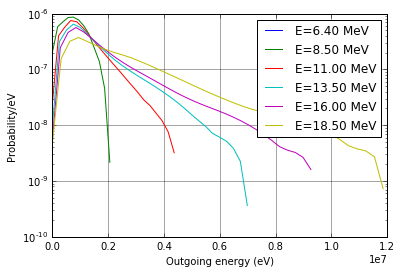

In [16]:
for e_in, e_out_dist in zip(dist.energy[::5], dist.energy_out[::5]):
    plt.semilogy(e_out_dist.x, e_out_dist.p, label='E={:.2f} MeV'.format(e_in/1e6))
plt.ylim(ymax=1e-6)
plt.legend()
plt.xlabel('Outgoing energy (eV)')
plt.ylabel('Probability/eV')
plt.show()

There is also `summed_reactions` attribute for cross sections (like total) which are built from summing up other cross sections.

In [17]:
pprint(list(gd157.summed_reactions.values()))

[<Reaction: MT=101 (n,disappear)>,
 <Reaction: MT=27 (n,absorption)>,
 <Reaction: MT=4 (n,level)>,
 <Reaction: MT=3>,
 <Reaction: MT=1 (n,total)>]


Note that the cross sections for these reactions are represented by the `Sum` class rather than `Tabulated1D`. They do not support the `x` and `y` attributes.

In [18]:
gd157[27].xs

{'294K': <openmc.data.function.Sum at 0x7fc3263b16a0>}

## Unresolved resonance probability tables

We can also look at unresolved resonance probability tables which are stored in a `ProbabilityTables` object. In the following example, we'll create a plot showing what the total cross section probability tables look like as a function of incoming energy.

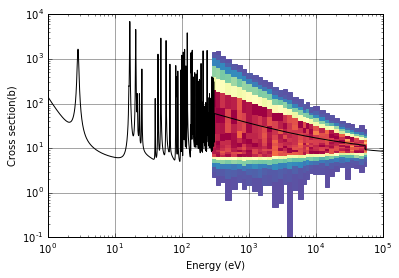

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)
cm = matplotlib.cm.Spectral_r

# Determine size of probability tables
urr = gd157.urr['294K']
n_energy = urr.table.shape[0]
n_band = urr.table.shape[2]

for i in range(n_energy):
    # Get bounds on energy
    if i > 0:
        e_left = urr.energy[i] - 0.5*(urr.energy[i] - urr.energy[i-1])
    else:
        e_left = urr.energy[i] - 0.5*(urr.energy[i+1] - urr.energy[i])

    if i < n_energy - 1:
        e_right = urr.energy[i] + 0.5*(urr.energy[i+1] - urr.energy[i])
    else:
        e_right = urr.energy[i] + 0.5*(urr.energy[i] - urr.energy[i-1])
        
    for j in range(n_band):
        # Determine maximum probability for a single band
        max_prob = np.diff(urr.table[i,0,:]).max()
        
        # Determine bottom of band
        if j > 0:
            xs_bottom = urr.table[i,1,j] - 0.5*(urr.table[i,1,j] - urr.table[i,1,j-1])
            value = (urr.table[i,0,j] - urr.table[i,0,j-1])/max_prob
        else:
            xs_bottom = urr.table[i,1,j] - 0.5*(urr.table[i,1,j+1] - urr.table[i,1,j])
            value = urr.table[i,0,j]/max_prob

        # Determine top of band
        if j < n_band - 1:
            xs_top = urr.table[i,1,j] + 0.5*(urr.table[i,1,j+1] - urr.table[i,1,j])
        else:
            xs_top = urr.table[i,1,j] + 0.5*(urr.table[i,1,j] - urr.table[i,1,j-1])
    
        # Draw rectangle with appropriate color
        ax.add_patch(Rectangle((e_left, xs_bottom), e_right - e_left, xs_top - xs_bottom,
                     color=cm(value)))

# Overlay total cross section
ax.plot(gd157.energy['294K'], total.xs['294K'](gd157.energy['294K']), 'k')

# Make plot pretty and labeled
ax.set_xlim(1.0, 1.0e5)
ax.set_ylim(1e-1, 1e4)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Energy (eV)')
ax.set_ylabel('Cross section(b)')

## Converting ACE to HDF5

The `openmc.data` package can also read ACE files and output HDF5 files. ACE files can be read with the `openmc.data.IncidentNeutron.from_ace(...)` factory method.

In [20]:
filename = '/opt/data/ace/nndc/293.6K/Gd_157_293.6K.ace'
gd157_ace = openmc.data.IncidentNeutron.from_ace(filename)
gd157_ace

<IncidentNeutron: Gd157>

We can store this formerly ACE data as HDF5 with the `export_to_hdf5()` method.

In [21]:
gd157_ace.export_to_hdf5('gd157.h5', 'w')

With few exceptions, the HDF5 file encodes the same data as the ACE file.

In [22]:
gd157_reconstructed = openmc.data.IncidentNeutron.from_hdf5('gd157.h5')
gd157_ace[16].xs['294K'].y - gd157_reconstructed[16].xs['294K'].y

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

And one of the best parts of using HDF5 is that it is a widely used format with lots of third-party support. You can use `h5py`, for example, to inspect the data.

In [23]:
h5file = h5py.File('gd157.h5', 'r')
main_group = h5file['Gd157/reactions']
for name, obj in sorted(list(main_group.items()))[:10]:
    if 'reaction_' in name:
        print('{}, {}'.format(name, obj.attrs['label'].decode()))

reaction_002, (n,elastic)
reaction_016, (n,2n)
reaction_017, (n,3n)
reaction_022, (n,na)
reaction_024, (n,2na)
reaction_028, (n,np)
reaction_041, (n,2np)
reaction_051, (n,n1)
reaction_052, (n,n2)
reaction_053, (n,n3)


In [24]:
n2n_group = main_group['reaction_016']
pprint(list(n2n_group.values()))

[<HDF5 group "/Gd157/reactions/reaction_016/product_0" (2 members)>,
 <HDF5 group "/Gd157/reactions/reaction_016/294K" (1 members)>,
 <HDF5 group "/Gd157/reactions/reaction_016/product_1" (2 members)>]


So we see that the hierarchy of data within the HDF5 mirrors the hierarchy of Python objects that we manipulated before.

In [25]:
n2n_group['294K/xs'].value

array([  0.00000000e+00,   3.02679600e-13,   1.29110100e-02,
         6.51111000e-02,   3.92627000e-01,   5.75226800e-01,
         6.96960000e-01,   7.39937800e-01,   9.63545000e-01,
         1.14213000e+00,   1.30802000e+00,   1.46350000e+00,
         1.55760000e+00,   1.64055000e+00,   1.68896000e+00,
         1.71140000e+00,   1.73945000e+00,   1.78207000e+00,
         1.81665000e+00,   1.84528000e+00,   1.86540900e+00,
         1.86724000e+00,   1.88155800e+00,   1.88156000e+00,
         1.88180000e+00,   1.89447000e+00,   1.86957000e+00,
         1.82120000e+00,   1.71600000e+00,   1.60054000e+00,
         1.43162000e+00,   1.28346000e+00,   1.10166000e+00,
         1.06530000e+00,   9.30730000e-01,   8.02980000e-01,
         7.77740000e-01])